# Boxsize 1x1

## $R/L_T$ = 6.0

#### $N_s$ = 16, $N_\mu$ = 6, $N_{vpar}$ = 48, $N_x$ = 43

In [1]:
# Import modules
import sys, os, h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.transforms import Bbox

filepath = os.getcwd()
homepath = filepath.split('data')[0]
sys.path.insert(1, homepath + 'python')

import zonalflow, h5tools, derivative, plot

# Plot parameter
%matplotlib inline
plot.parameters(True, 22, (24,8), 300)

In [2]:
# File import and Create picture folder
data = filepath[filepath.find('data/')+len('data/'):filepath.rfind('/boxsize')]
path = filepath.split(data + '/')[1]

resolution = path.replace('/', '_')
rlt = data.split("rlt",1)[1]
filename = 'data.h5'
f = h5py.File(filename,"r+")

picpath = homepath+'pictures/'+data+'/'+path+'/'
## Create target Directory if don't exist
if not os.path.exists(picpath):
    os.makedirs(picpath)

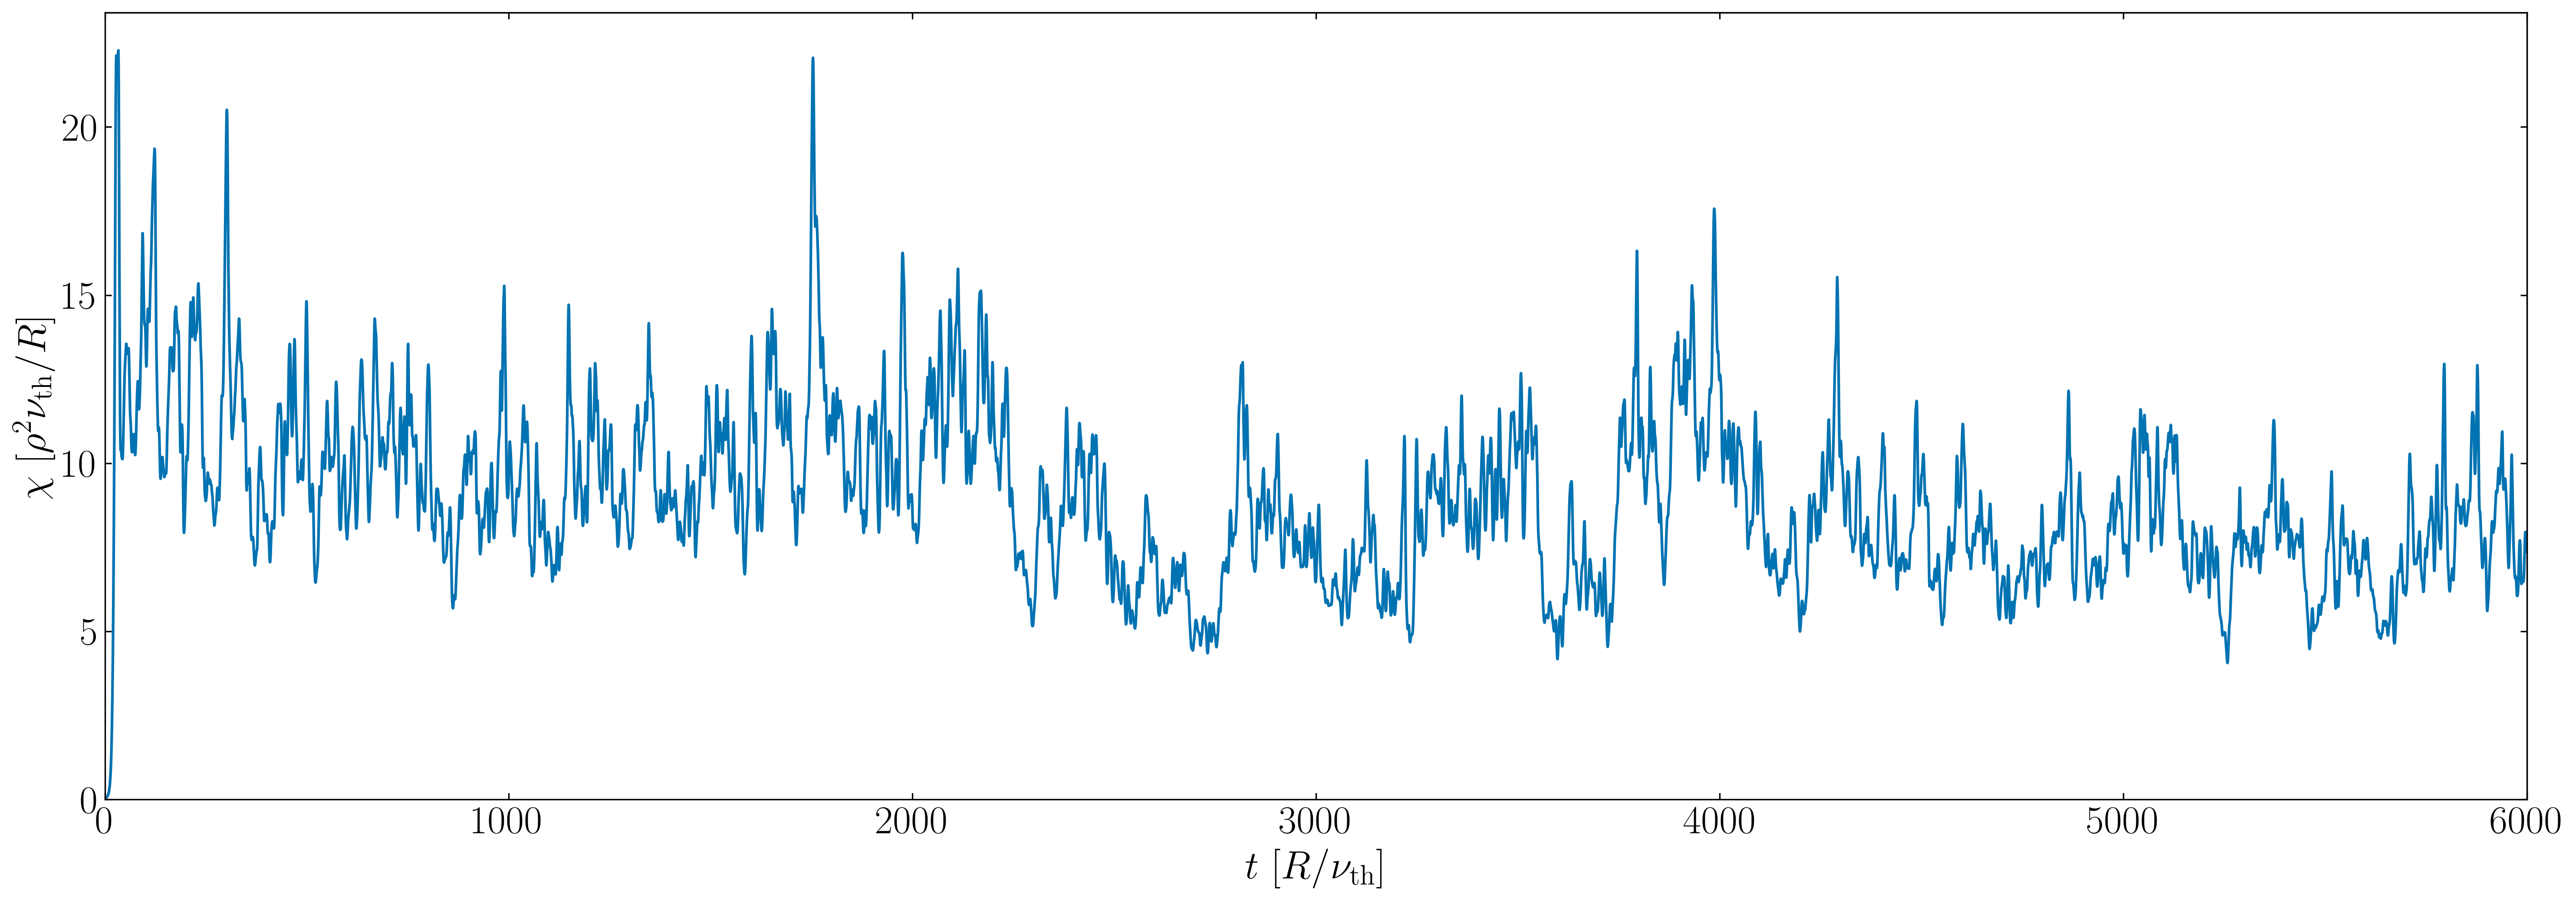

In [3]:
# Heat flux
eflux_data, time = zonalflow.get_eflux_time(f)

plot.eflux_time(time, eflux_data, (24,8))
plt.savefig(picpath+data+'_'+resolution+'_eflux.pdf', bbox_inches='tight')

In [4]:
# Finite Difference for shearing rate omega_ExB
wexb, rad_coord, rad_boxsize, ddphi, dx, zonal_pot = zonalflow.get_shearingrate_radialcoordinate_radialboxsize_ddphi_dx_zonalpot(f)

print('rad_boxsize :', rad_boxsize, '; stepsize :',dx)

Loaded from data
rad_boxsize : 76.27048929506809 ; stepsize : 1.0895784185009727


Loaded from data


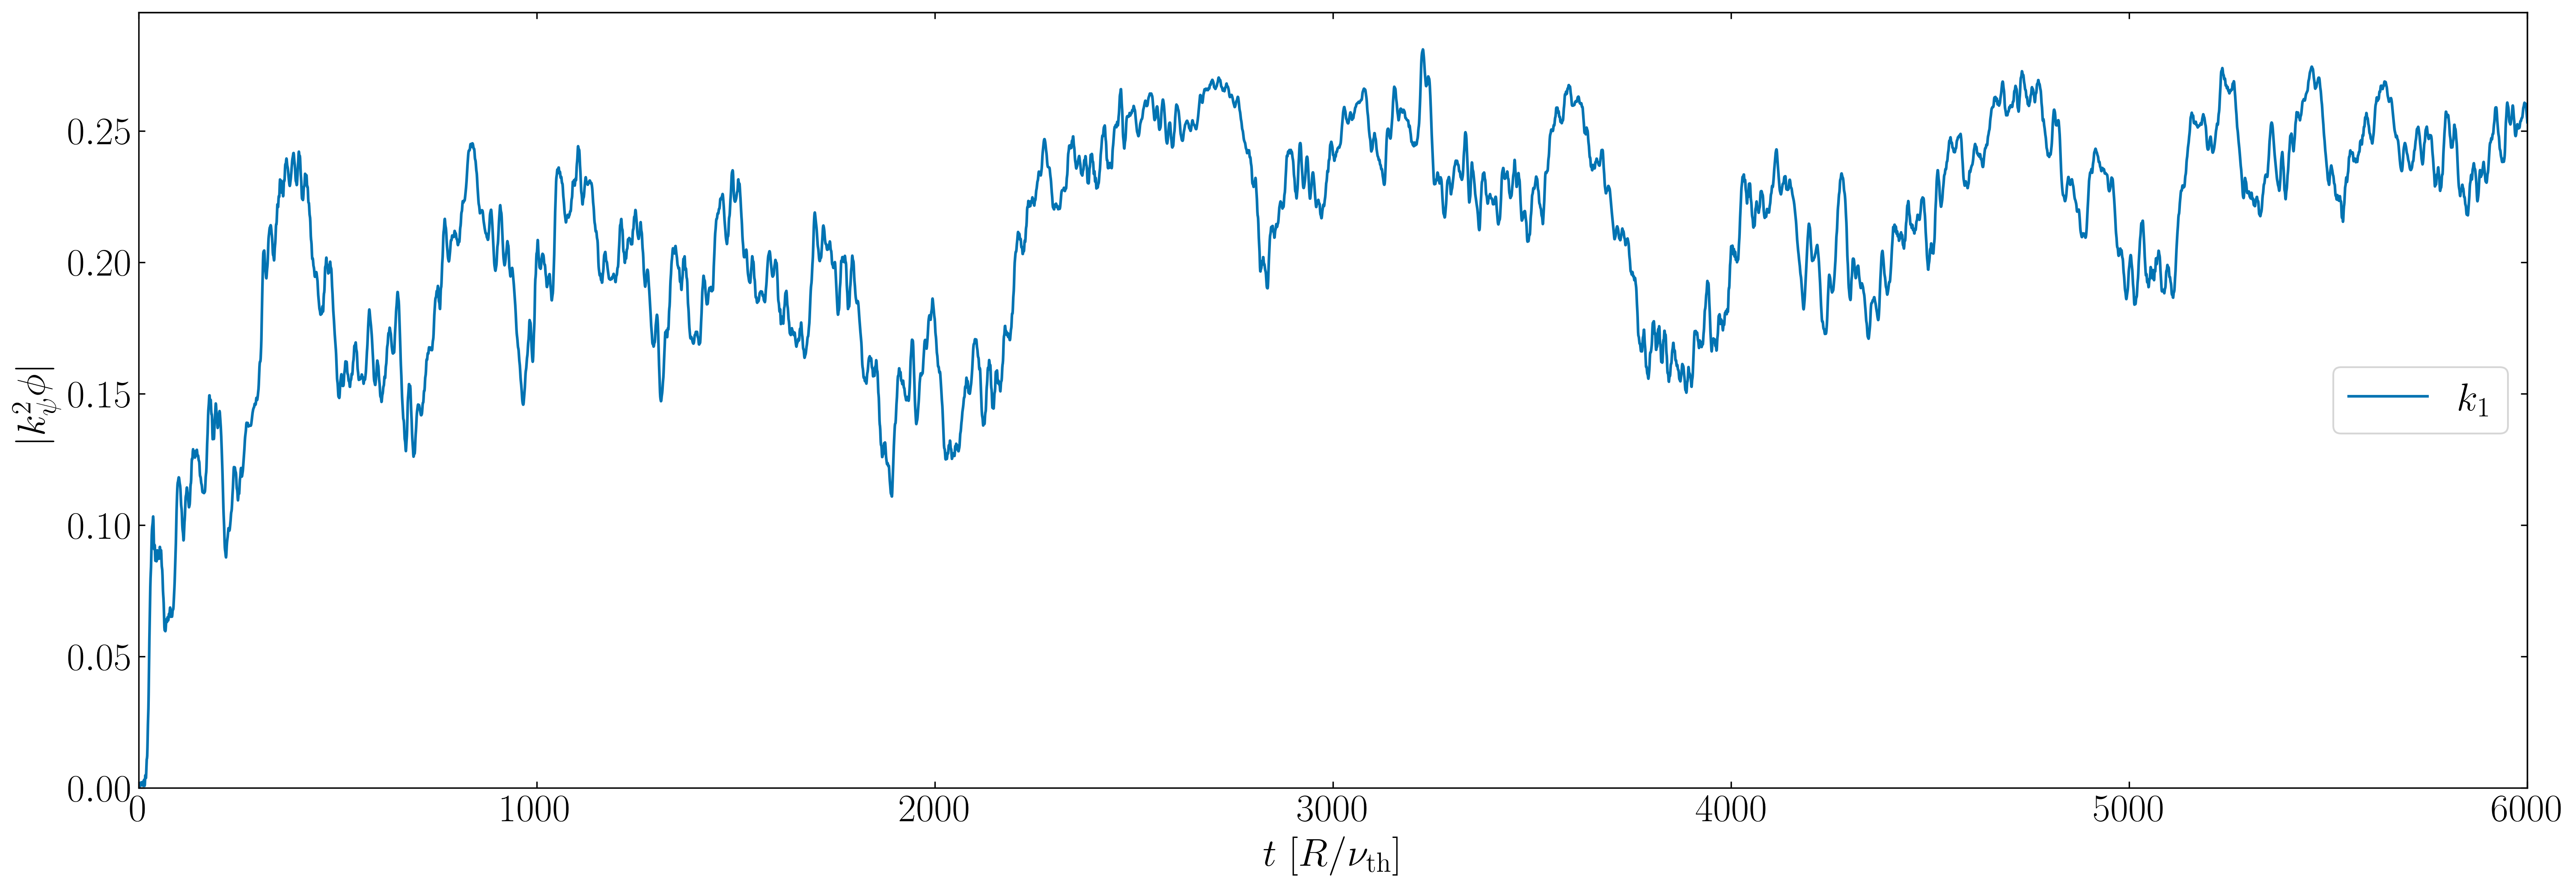

In [5]:
# Fourier plot of time domain

wexb_max = zonalflow.get_max_shearingrate(f, wexb, time, 5)

plot.max_shearingrate_time(time, wexb_max, 1, (24,8))
plt.savefig(picpath+data+'_'+resolution+'_wexb_max.pdf', bbox_inches='tight')

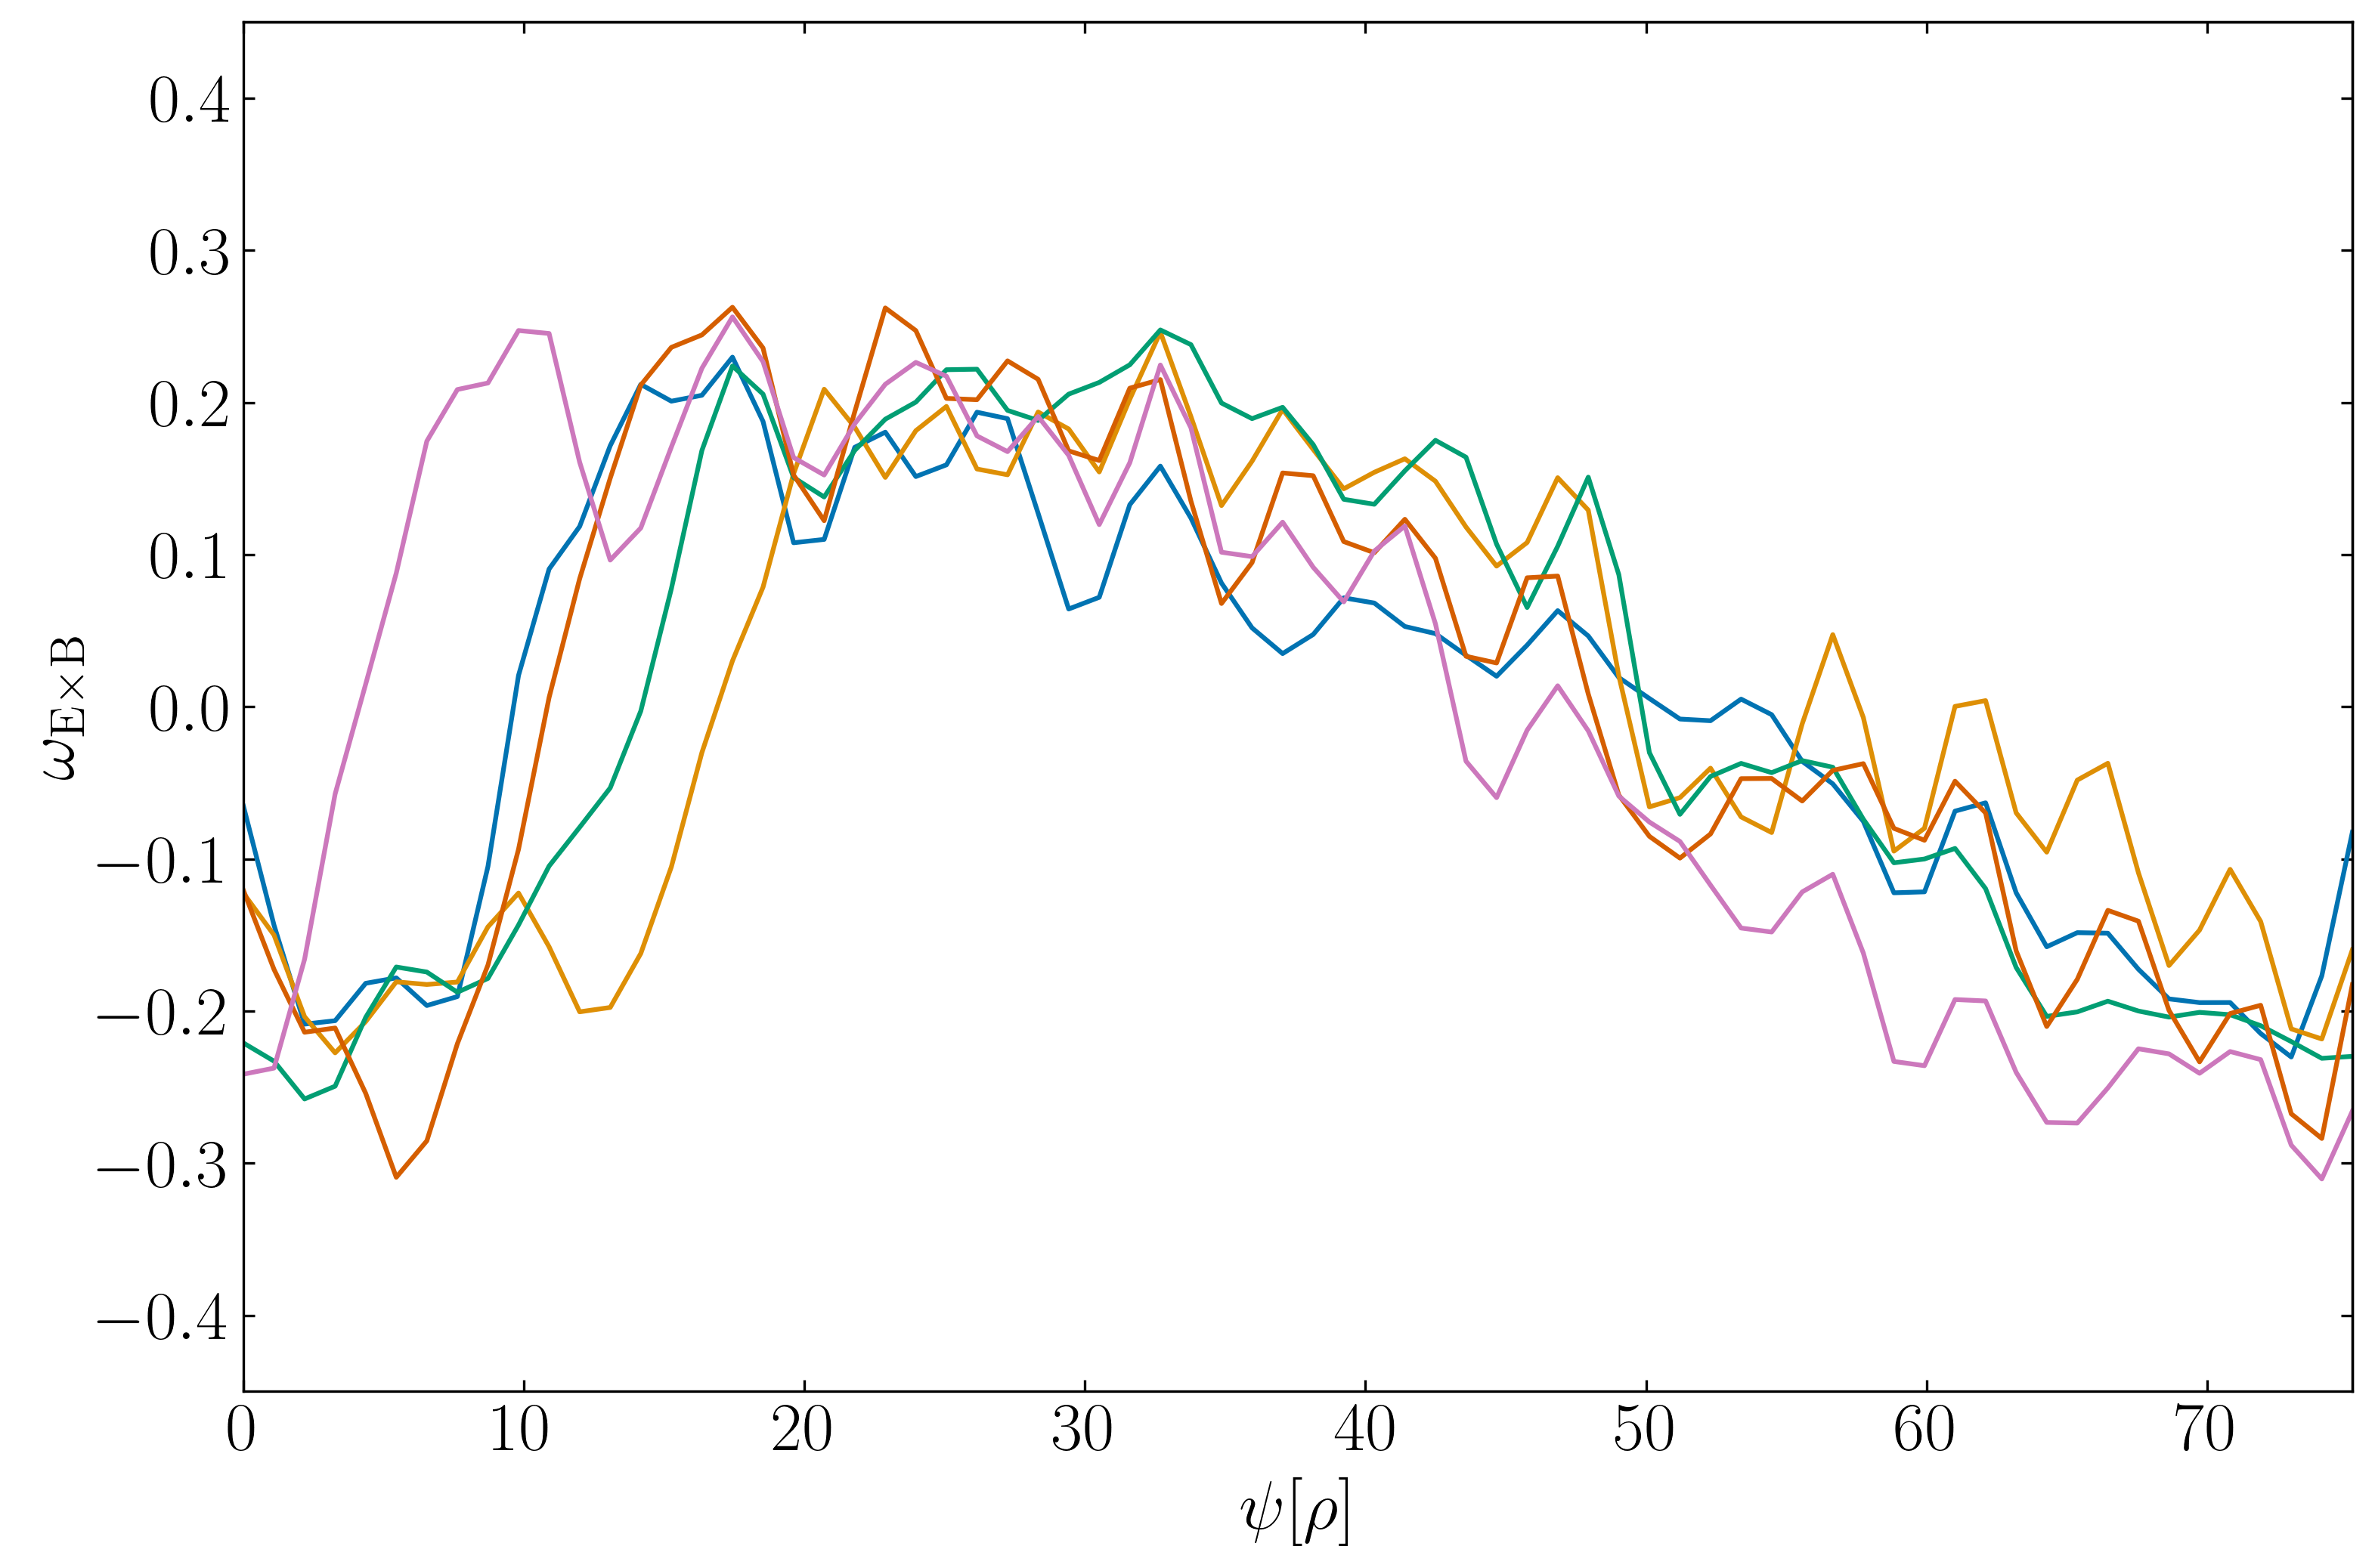

In [6]:
# Plot all shearing rate with mean overe intervall in 1000 steps
plot.all_shearingrate_radialcoordinate(rad_coord, wexb, (12,8), 2000)
plt.savefig(picpath+data+'_'+resolution+'_wexb_all.pdf', bbox_inches='tight')

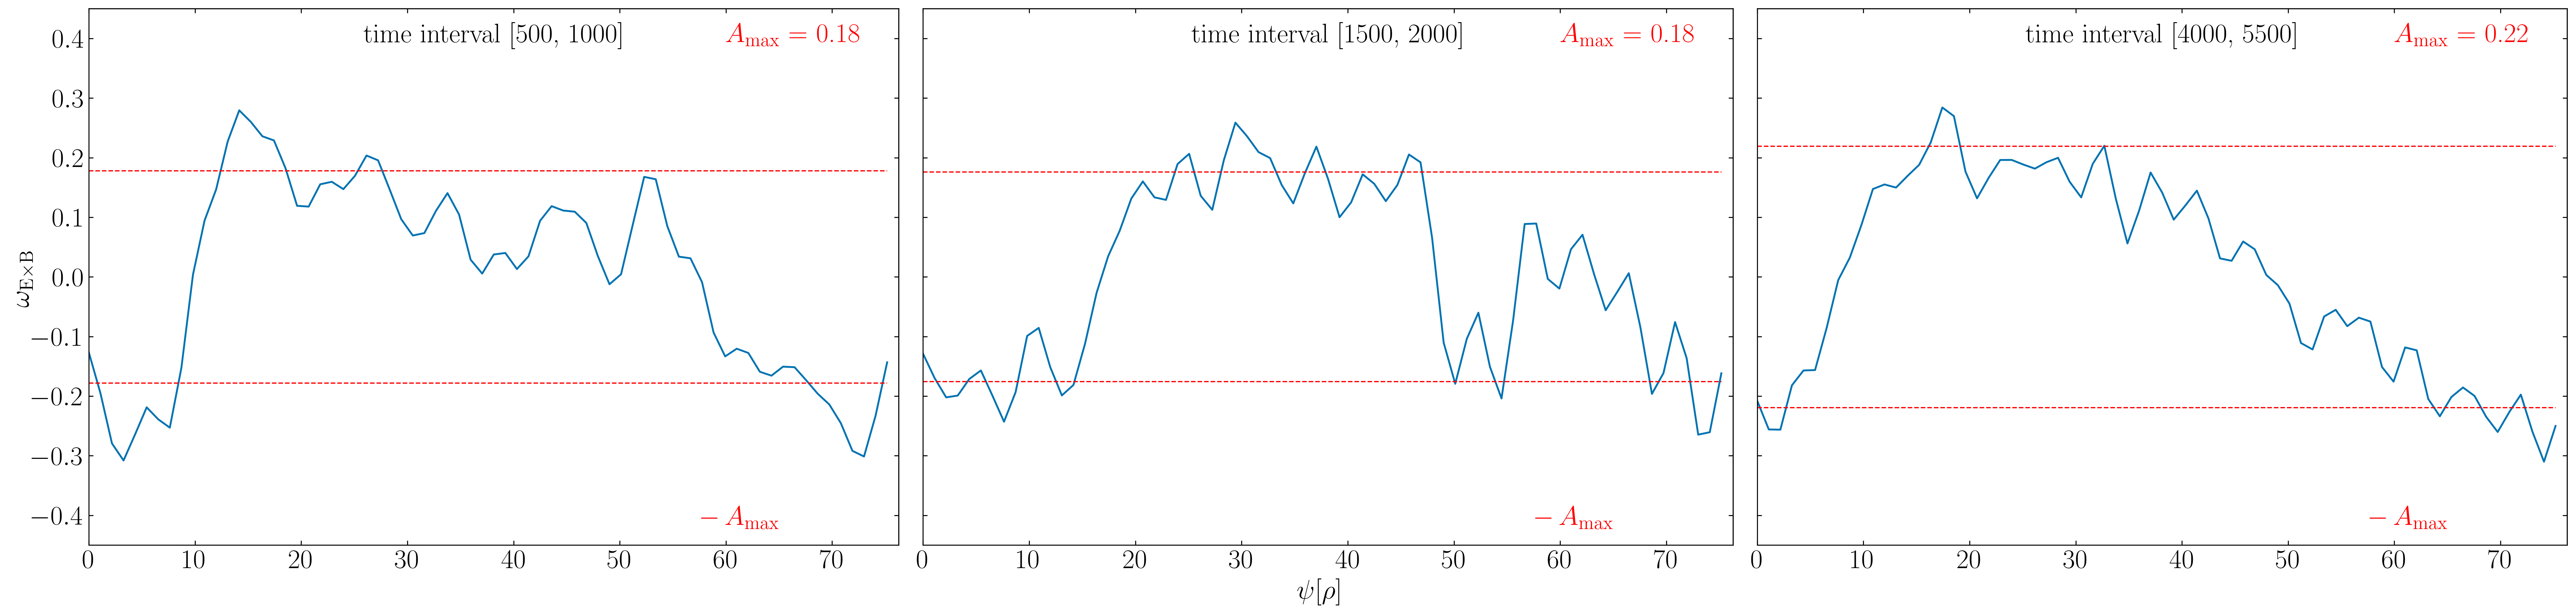

In [7]:
# Time interval to display shearing rate
interval = np.array([[ 500, 1500, 4000],
                     [1000, 2000, 5500]])

# Dimension Subplot
for i in [3,2,1]:
    if interval.shape[1] % i == 0:
        xdim, ydim = i, int(interval.shape[1]/i)
        break

grid_x, grid_y = np.arange(xdim), np.arange(ydim)

fig, ax = plt.subplots(ydim, xdim,figsize=(12*xdim, 8*ydim), sharey=True, sharex=True, squeeze=True)

i = 0

for y in grid_y:
    for x in grid_x:
        start, end = zonalflow.get_index_from_value(time,interval[0][i]) , zonalflow.get_index_from_value(time,interval[1][i])
        start_time, end_time = interval[0][i], interval[1][i]
        
        # Shearing rate with mean over time
        wexb_rad_mean, wexb_rad_middle = zonalflow.get_mean_middle_shearingrate(start, end, wexb)
        # FT{shearing rate}
        wexb_rad_mean_amp, wexb_rad_mean_amp_max = zonalflow.get_fft_mean_max_shearingrate_amplitude(wexb_rad_mean)

        plot.mean_shearingrate_radialcoordinate_subplot(rad_coord, rad_boxsize, wexb_rad_mean, wexb_rad_middle, wexb_rad_mean_amp_max, 
                                                        ax, x, y, xdim, ydim, start_time, end_time)
        
        i += 1

fig.text(0.51, 0.05, r'$\psi[\rho]$', ha='center')
fig.text(0.1, 0.5, r'$\omega_{\mathrm{E \times B}}$', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.03, hspace=0.05)
plt.savefig(picpath+data+'_'+resolution+'_wexb_evolution.pdf', bbox_inches='tight')

In [8]:
# write evaluated data into h5 file

data_eval = [dx, ddphi, zonal_pot, wexb, wexb_max]
groupname = ['evaluation' + '/' + x for x in ['derivative_stepsize', 'second_derivative_phi', 'zonalflow_potential', 
                                              'shearing_rate', 'shearing_rate_maximum']]

h5tools.hdf5_write_data(f, data_eval, groupname)